# NARR: Subsetting and OPeNDAP

## About the Dataset

This tutorial uses data from NOAA's [North American Regional Reanalysis](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) (NARR)

> The North American Regional Reanalysis (NARR) is a model produced by the National Centers for Environmental Prediction (NCEP) that generates reanalyzed data for temperature, wind, moisture, soil, and dozens of other parameters. The NARR model assimilates a large amount of observational data from a variety of sources to produce a long-term picture of weather over North America.

For this recipe, we will access the data via [OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap), a widely-used API for remote access of environmental data over HTTP.
A key point is that, since we use using OPeNDAP, _there are no input files to download / cache_. We open the data directly from the remote server.

The data we will use are catalogged here (3D data on pressure levels): <https://psl.noaa.gov/thredds/catalog/Datasets/NARR/pressure/catalog.html>

Let's peek at one file. Xarray should automatically do the right thing with the OPeNDAP url. But just to be safe, we can pass the option, `engine='netcdf4'`, which is needed to open OPeNDAP links correctly. (We will need this again later when writing our recipe.)

In [9]:
import xarray as xr
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc"
ds = xr.open_dataset(url, engine='netcdf4', decode_cf="all")
ds

/Users/rabernat/mambaforge/envs/pangeo-forge-recipes/lib/python3.9/site-packages/xarray/conventions.py:523: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Jan  8 02:35:07 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

This is just one file.
But it's a very big file (several GB)!
We will want to break it up by specifying `target_chunks` when we write to Zarr.

In [2]:
ds.air._ChunkSizes

array([  1,   1, 277, 349], dtype=int32)

This tells us that we can subset in the `time` or `level` dimensions, but problably should avoid subsetting in the `x` and `y` dimensions.

Also note the presence of the `Lambert_Conformal` data variable. This should be a coordinate. So we will need to write a custom transform to make that change.

## Define File Pattern

We are now ready to define the `FilePattern` for the recipe. There is one file per month. So we start with a function like this:

In [3]:
def format_function(time):
    return f"https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.{time}.nc"

To keep things short and simple for this tutorial, we will just use one file, and subset it into many chunks.
But we could easily add more months to build up the entire dataset.
Since each file is monthly, and the number of days per months varies, we cannot set `nitems_per_input` in the `ConcatDim`.

```{note}
It's important that we specify `file_type="opendap"` when creating a FilePattern with OPeNDAP URLs.
OPeNDAP is actually an API, so there are no files to download. 
```

In [4]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
time_dim = ConcatDim("time", ["197901"])
pattern = FilePattern(format_function, time_dim, file_type="opendap")
pattern

<FilePattern {'time': 1}>

## Define the Pipeline


In [5]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

In [10]:
from pangeo_forge_recipes.transforms import Indexed, T

class SetProjectionAsCoord(beam.PTransform):
    """A preprocessing function which will assign the `Lambert_Conformal` variable as a coordinate variable."""

    @staticmethod
    def _set_projection_as_coord(item: Indexed[T]) -> Indexed[T]:
        index, ds = item
        ds = ds.set_coords(["Lambert_Conformal"])
        return index, ds

    def expand(self, pcoll: beam.PCollection) -> beam.PCollection:
        return pcoll | beam.Map(self._set_projection_as_coord)

We now define a target location for our recipe. Here we just use a temporary directory.

In [11]:
import os
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_root = td.name
store_name = "output.zarr"
target_store = os.path.join(target_root, store_name)
target_store

'/var/folders/kl/7rfdrpx96bb0rhbnl5l2dnkw0000gn/T/tmp_uj6socr/output.zarr'

Now we put together the necessary PTransforms.

In [12]:
transforms = (
    beam.Create(pattern.items())
    | OpenWithXarray(file_type=pattern.file_type)
    | SetProjectionAsCoord()
    | StoreToZarr(
        store_name=store_name,
        target_root=target_root,
        combine_dims=pattern.combine_dim_keys,
        target_chunks={"time": 1}
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenWithXarray|SetProjectionAsCoord|StoreToZarr] at 0x149eaf790>

In [ ]:
with beam.Pipeline() as p:
    p | transforms

## Check The Outputs

In [14]:
ds_target =  xr.open_dataset(target_store, engine="zarr", chunks={})
ds_target

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
    Lambert_Conformal  int32 ...
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
Data variables:
    air                (time, level, y, x) float32 dask.array<chunksize=(1, 29, 277, 349), meta=np.ndarray>
Attributes: (12/16)
    Conventions:                     CF-1.2
    DODS_EXTRA.Unlimited_Dimension:  time
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    dataset_title:                   NCEP North American Regional Reanalysis ...
    ...                              ...
    platform:                        Model
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    standardpar1:                    50.0
    standardpar2:                    50.000001
    title:                           8x Daily NARR

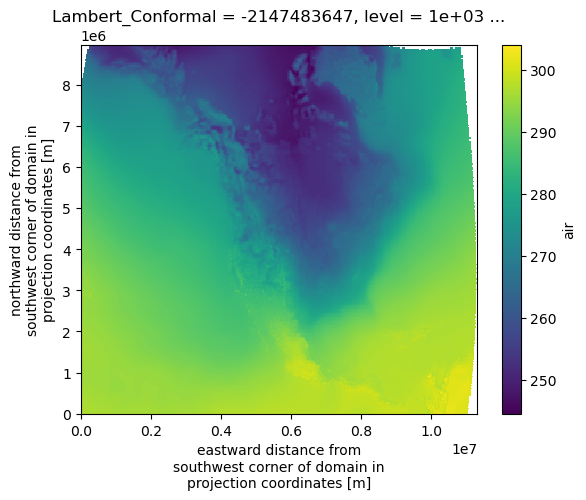

In [16]:
ds_target.air.isel(level=0).mean("time").plot()